## Clustering analysis performed for hotels data coming from Bidroom DB

In [378]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

### Importing Libraries

In [379]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA
##libraries needed for clustering analysis
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

### Importing file with data

In [380]:
file = pd.read_csv("Documents/clustering/hotelClusterAnalysis3.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             2000 non-null   int64  
 1   hotel_city           2000 non-null   int64  
 2   hotel_type           2000 non-null   int64  
 3   hotel_country        1999 non-null   object 
 4   hotel_currency_code  2000 non-null   object 
 5   hotel_lat            2000 non-null   float64
 6   hotel_lon            2000 non-null   float64
 7   hotel_distance       2000 non-null   float64
 8   rooms_count          2000 non-null   int64  
 9   room_type_en         420 non-null    object 
 10  room_type_no         420 non-null    float64
 11  label                60 non-null     object 
 12  amenity              2000 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage: 203.2+ KB


In [381]:
### puting every room type to separate column 
## and as a value the number of such room types for a given hotel
def crgeatingRoomsMatrix(df):
    rooms = df
    rooms = rooms.pivot(index="hotel_id", columns = "room_type_en", values="room_type_no" )
    rooms = rooms.reset_index()
    rooms.columns = rooms.columns.str.lower()
    rooms = rooms.fillna(0)
    return rooms

In [382]:
rooms = creatingRoomsMatrix(fileWorking[["hotel_id", "room_type_en", "room_type_no"]])

In [383]:
fileWorking = fileWorking.merge(rooms, how="left", on="hotel_id")
fileWorking = fileWorking.drop(columns=["room_type_en","room_type_no",np.nan])
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             2000 non-null   int64  
 1   hotel_city           2000 non-null   int64  
 2   hotel_type           2000 non-null   int64  
 3   hotel_country        1999 non-null   object 
 4   hotel_currency_code  2000 non-null   object 
 5   hotel_lat            2000 non-null   float64
 6   hotel_lon            2000 non-null   float64
 7   hotel_distance       2000 non-null   float64
 8   rooms_count          2000 non-null   int64  
 9   label                60 non-null     object 
 10  amenity              2000 non-null   object 
 11  apartment            2000 non-null   float64
 12  double               2000 non-null   float64
 13  family               2000 non-null   float64
 14  others               2000 non-null   float64
 15  quadruple            2000 non-null   f

In [384]:
### putting amenities to separate columns
amenities =  []
for x in fileWorking["amenity"]:
    x = x.split(sep=',')
    amenities = amenities + x
amenities = list(set(amenities))

In [385]:
import re
amenitiesAll = fileWorking[["hotel_id","amenity"]]
for x in amenities:
    com = '(.*)?('+ x +')(.*)?'
    amenitiesAll[x]=[1 if re.search(com,a) is not None else 0 for a in amenitiesAll["amenity"]]

# preparing dataset to visualize amenities correlation heatmap and frequency heatmap
amenitiesToVisualize = amenitiesAll.drop(columns=["amenity", "hotel_id"])

## dataset that will be merged to the working file
amenitiesAll = amenitiesAll.drop(columns=["amenity"])

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Correlation score heatmap for hotel amenities')

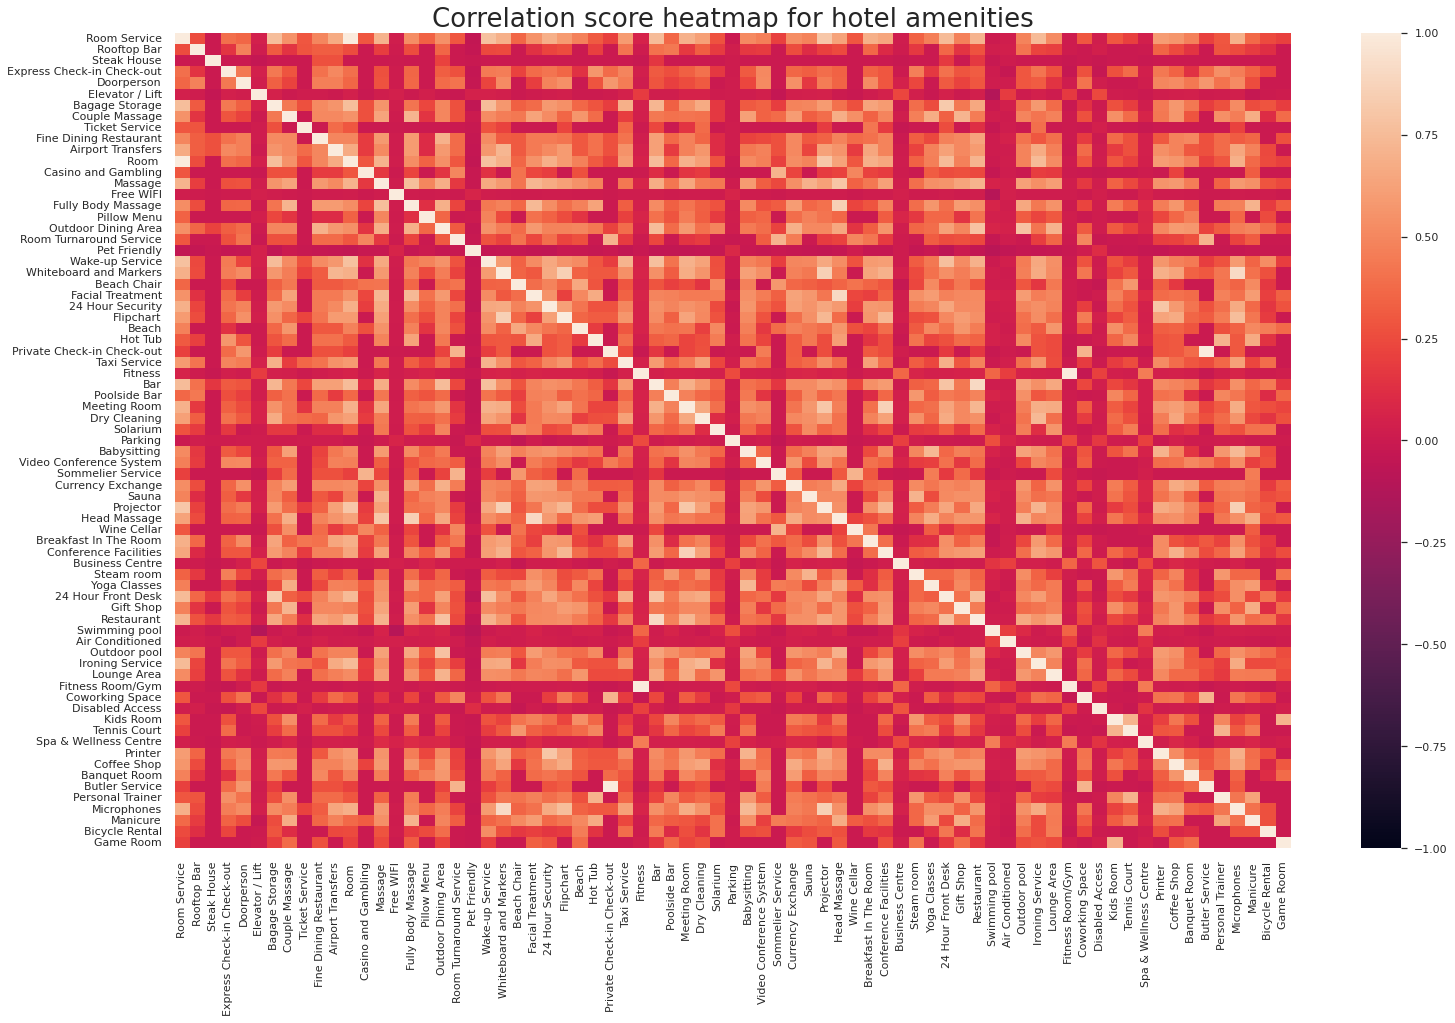

In [386]:
### visualizing correlation score as a heatmap

fig, ax = plt.subplots(figsize = (25,15))
sns.heatmap(amenitiesToVisualize.corr(), vmin=-1, vmax=1)
plt.rcParams.update({'font.size': 26})
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation score heatmap for hotel amenities", fontsize=26)

In [387]:
### preparing dataset containing the frequency for each amenity
amenities_freq_mat = np.dot(amenitiesToVisualize.T, amenitiesToVisualize)
amenities_freq = pd.DataFrame(amenities_freq_mat, columns = amenitiesToVisualize.columns, index = amenitiesToVisualize.columns)

Text(0.5, 1.0, 'Frequency heatmap for hotel amenities')

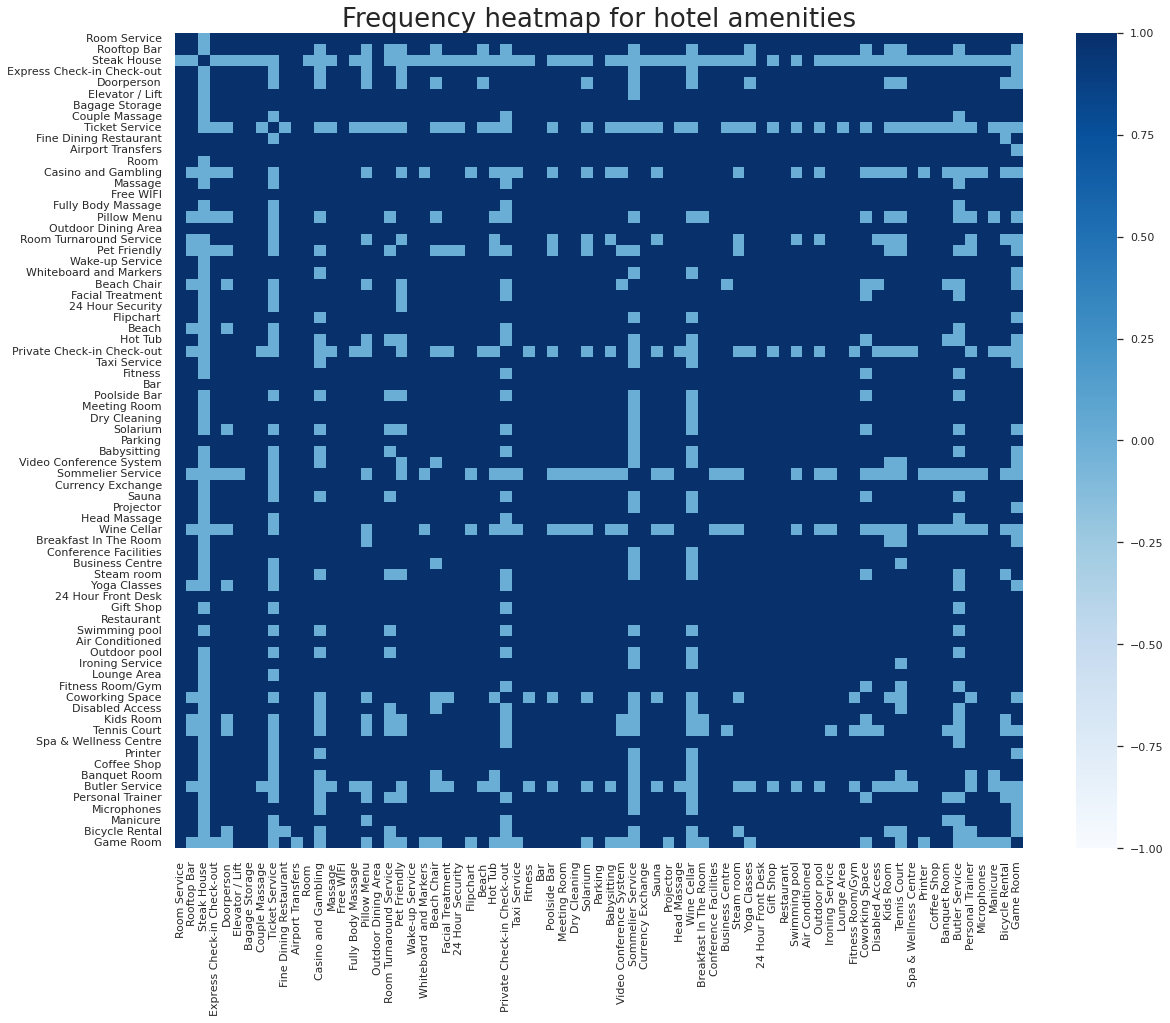

In [388]:
### visualizing frequency heatmap
fig, ax = plt.subplots(figsize = (19,15))
sns.heatmap(amenities_freq, cmap = "Blues",vmin=-1, vmax=1)
plt.rcParams.update({'font.size': 22})
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
plt.title("Frequency heatmap for hotel amenities", fontsize=26)

In [389]:
### creating the final working file for analysis
fileWorking = fileWorking.merge(amenitiesAll, how="left", on="hotel_id")
fileWorking = fileWorking.drop(columns=["amenity"])
fileWorking.columns = fileWorking.columns.str.lower()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 94 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    2000 non-null   int64  
 1   hotel_city                  2000 non-null   int64  
 2   hotel_type                  2000 non-null   int64  
 3   hotel_country               1999 non-null   object 
 4   hotel_currency_code         2000 non-null   object 
 5   hotel_lat                   2000 non-null   float64
 6   hotel_lon                   2000 non-null   float64
 7   hotel_distance              2000 non-null   float64
 8   rooms_count                 2000 non-null   int64  
 9   label                       60 non-null     object 
 10  apartment                   2000 non-null   float64
 11  double                      2000 non-null   float64
 12  family                      2000 non-null   float64
 13  others                      2000 

## Data Cleaning

### Removing duplicates

In [390]:
filesWorkingCleaned = fileWorking.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

In [391]:
def mappingCategoricalData(seriesUnique):
    catData = {}
    for i, code in enumerate(seriesUnique):
        catData[code] = i+1
    return catData

#### handling information for hotel_currency_code

In [392]:
filesWorkingCleaned["hotel_currency_code"].isna().sum()

0

In [393]:
curr = filesWorkingCleaned["hotel_currency_code"].unique()
currCode = mappingCategoricalData(curr)
filesWorkingCleaned["hotel_currency_code"] = filesWorkingCleaned["hotel_currency_code"].map(currCode)

#### handling information for hotel_country

In [394]:
filesWorkingCleaned["hotel_country"].isna().sum()

1

In [395]:
co = filesWorkingCleaned["hotel_country"].unique()
country = mappingCategoricalData(co)
filesWorkingCleaned["hotel_country"] = filesWorkingCleaned["hotel_country"].map(country)

#### handling information for rooms_count

In [396]:
filesWorkingCleaned["rooms_count"].isna().sum()

0

#### handling information for label

In [397]:
filesWorkingCleaned["label"].value_counts(dropna=False)

NaN          1940
green_key      60
Name: label, dtype: int64

In [398]:
filesWorkingCleaned["green_key"] = [1 if x == "green_key" else 0 for x in filesWorkingCleaned["label"]]
filesWorkingCleaned = filesWorkingCleaned.drop(columns=["label"])

#### handling information for hotel_lat and hotel_lon

In [399]:
filesWorkingCleaned["hotel_lat"] = filesWorkingCleaned["hotel_lat"].apply(lambda x: round(x,5))
filesWorkingCleaned["hotel_lon"] = filesWorkingCleaned["hotel_lon"].apply(lambda x: round(x,5))

In [400]:
filesWorkingCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 94 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hotel_id                    2000 non-null   int64  
 1   hotel_city                  2000 non-null   int64  
 2   hotel_type                  2000 non-null   int64  
 3   hotel_country               2000 non-null   int64  
 4   hotel_currency_code         2000 non-null   int64  
 5   hotel_lat                   2000 non-null   float64
 6   hotel_lon                   2000 non-null   float64
 7   hotel_distance              2000 non-null   float64
 8   rooms_count                 2000 non-null   int64  
 9   apartment                   2000 non-null   float64
 10  double                      2000 non-null   float64
 11  family                      2000 non-null   float64
 12  others                      2000 non-null   float64
 13  quadruple                   2000 

#### Visualize heatmap for all hotel characteristics

Text(0.5, 1.0, 'Correlation Heatmap for final hotel characteristics')

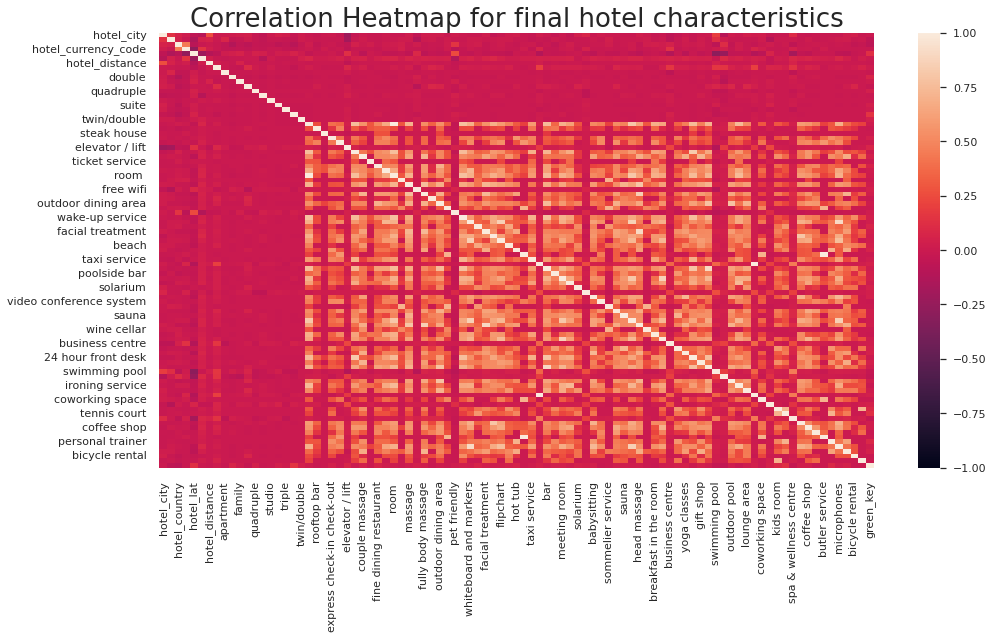

In [401]:
toPlot = filesWorkingCleaned.drop(columns=["hotel_id"])
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(toPlot.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for final hotel characteristics", fontdict={"fontsize":26})

## Data Reduction

In [402]:
### creating function that detects strong correlation 
### and returns list of characteristics that should should be removed 
def calc_vif(df, col_names):
    # Multicollinearity detection
    vif = pd.DataFrame()

    variables = df[col_names]
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[vif["VIF"].isnull()]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

def reduce_dimensions_by_pca(df):
    # reduce dimentions if there are still a lot of variables
    pca = PCA(n_components=0.95)
    numpy_arr = pca.fit_transform(df)
    df_reduced = pd.DataFrame(data=numpy_arr.flatten())

    return df_reduced

In [403]:
toPlot.columns

Index(['hotel_city', 'hotel_type', 'hotel_country', 'hotel_currency_code',
       'hotel_lat', 'hotel_lon', 'hotel_distance', 'rooms_count', 'apartment',
       'double', 'family', 'others', 'quadruple', 'single', 'studio', 'suite',
       'triple', 'twin', 'twin/double', 'room service', 'rooftop bar',
       'steak house', 'express check-in check-out', 'doorperson',
       'elevator / lift', 'bagage storage', 'couple massage', 'ticket service',
       'fine dining restaurant', 'airport transfers', 'room ',
       'casino and gambling', 'massage', 'free wifi', 'fully body massage',
       'pillow menu', 'outdoor dining area', 'room turnaround service',
       'pet friendly', 'wake-up service', 'whiteboard and markers',
       'beach chair', 'facial treatment', '24 hour security', 'flipchart',
       'beach', 'hot tub', 'private check-in check-out', 'taxi service',
       'fitness', 'bar', 'poolside bar', 'meeting room', 'dry cleaning',
       'solarium', 'parking', 'babysitting', 'vide

In [404]:
toReduce = calc_vif(toPlot,['hotel_city', 'hotel_type', 'hotel_country', 'hotel_currency_code',
       'hotel_lat', 'hotel_lon', 'hotel_distance', 'rooms_count', 'apartment',
       'double', 'family', 'others', 'quadruple', 'single', 'studio', 'suite',
       'triple', 'twin', 'twin/double', 'room service', 'rooftop bar',
       'steak house', 'express check-in check-out', 'doorperson',
       'elevator / lift', 'bagage storage', 'couple massage', 'ticket service',
       'fine dining restaurant', 'airport transfers', 'room ',
       'casino and gambling', 'massage', 'free wifi', 'fully body massage',
       'pillow menu', 'outdoor dining area', 'room turnaround service',
       'pet friendly', 'wake-up service', 'whiteboard and markers',
       'beach chair', 'facial treatment', '24 hour security', 'flipchart',
       'beach', 'hot tub', 'private check-in check-out', 'taxi service',
       'fitness', 'bar', 'poolside bar', 'meeting room', 'dry cleaning',
       'solarium', 'parking', 'babysitting', 'video conference system',
       'sommelier service', 'currency exchange', 'sauna', 'projector',
       'head massage', 'wine cellar', 'breakfast in the room',
       'conference facilities', 'business centre', 'steam room',
       'yoga classes', '24 hour front desk', 'gift shop', 'restaurant',
       'swimming pool', 'air conditioned', 'outdoor pool', 'ironing service',
       'lounge area', 'fitness room/gym', 'coworking space', 'disabled access',
       'kids room', 'tennis court', 'spa & wellness centre', 'printer',
       'coffee shop', 'banquet room', 'butler service', 'personal trainer',
       'microphones', 'manicure', 'bicycle rental', 'game room', 'green_key'])

In [405]:
filesWorkingReduced = select_variables(filesWorkingCleaned, toReduce)
filesWorkingReduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               2000 non-null   int64  
 1   hotel_city             2000 non-null   int64  
 2   hotel_type             2000 non-null   int64  
 3   hotel_country          2000 non-null   int64  
 4   hotel_currency_code    2000 non-null   int64  
 5   hotel_lat              2000 non-null   float64
 6   hotel_lon              2000 non-null   float64
 7   hotel_distance         2000 non-null   float64
 8   rooms_count            2000 non-null   int64  
 9   apartment              2000 non-null   float64
 10  double                 2000 non-null   float64
 11  family                 2000 non-null   float64
 12  others                 2000 non-null   float64
 13  quadruple              2000 non-null   float64
 14  single                 2000 non-null   float64
 15  stud

Text(0.5, 1.0, 'Correlation heatmap for final hotel characteristics')

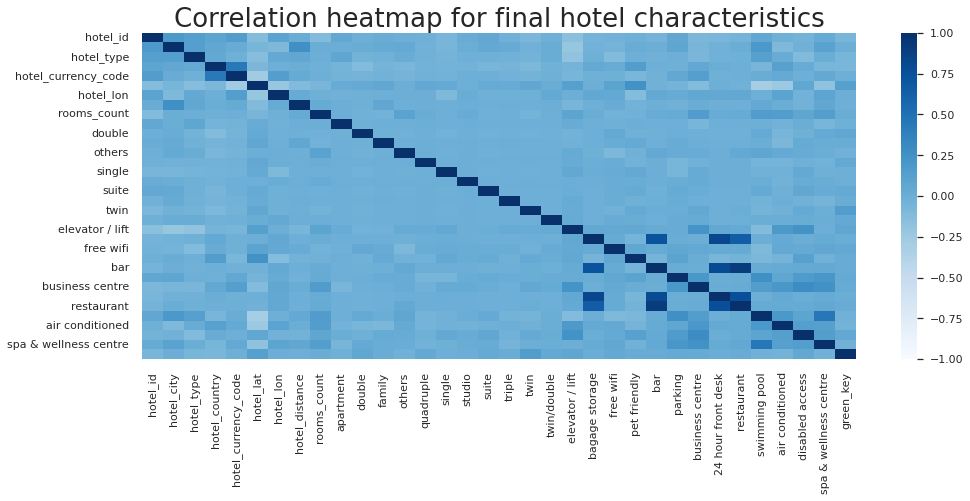

In [406]:
# ploting correlation heatmap for final hotel characteristics

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(filesWorkingReduced.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 22})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for final hotel characteristics", fontsize=26)

## Clustering analysis

### 1. For all reduced characteristics

In [407]:
# preparation data for scalling
x = filesWorkingReduced.loc[:,['hotel_city', 'hotel_type', 'hotel_country',
       'hotel_currency_code', 'hotel_lat', 'hotel_lon', 'hotel_distance',
       'rooms_count', 'apartment', 'double', 'family', 'others', 'quadruple',
       'single', 'studio', 'suite', 'triple', 'twin', 'twin/double',
       'air conditioned', 'free wifi', 'parking', 'restaurant',
       'elevator / lift', 'swimming pool', 'spa & wellness centre',
       'bagage storage', 'disabled access', 'bar', 'business centre',
       'pet friendly', '24 hour front desk', 'green_key']]
filesWorkingReduced.shape

(2000, 34)

### Scaling data

In [408]:
x_scaled = preprocessing.scale(x)

In [409]:
# for chosing the best nuber of clusters I generated silhouette_score for a range of clusters
scores = {}
for i in range(700,1500,50):
    km = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    y_means = km.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, km.labels_, metric="euclidean")
    scores[i] = score

In [410]:
# choosing number of clusters with the highest silhouette_score
highest = 700
for k,v in scores.items():
    if v > scores[highest]:
        highest = k

### Caculating KMeans for a given number of clusters

In [411]:
km = KMeans(n_clusters = highest, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x_scaled)

#### Adding found cluster numbers to dataframe

In [412]:

y_means = pd.DataFrame(y_means)
workingFileClusters = pd.concat([filesWorkingReduced, y_means], axis = 1)
workingFileClusters = workingFileClusters.rename(columns = {0: "Clusters"})
workingFileClusters.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,apartment,...,parking,business centre,24 hour front desk,restaurant,swimming pool,air conditioned,disabled access,spa & wellness centre,green_key,Clusters
0,1,22886,8,1,1,0.09102,32.47620,4.67,23,0.0,...,1,0,0,0,0,1,0,0,0,944
1,66,12,15,2,2,56.18580,-4.50023,7.25,1,0.0,...,1,1,0,0,1,0,0,1,0,236
2,68,15,4,3,3,24.46660,54.36660,1.16,84,0.0,...,1,1,0,0,1,1,0,0,0,517
3,73,15,5,3,3,24.49917,54.38133,2.76,248,0.0,...,1,1,0,0,1,1,1,1,1,403
4,168,22,4,4,4,30.40320,-9.59950,1.28,328,0.0,...,1,1,0,0,1,1,0,1,0,155


### 2. Reducing dimentions and applying the KMeans anaysis

In [413]:
filesWorkingReduced1 = filesWorkingReduced.set_index("hotel_id")
fileWorkingReduced2 = reduce_dimensions_by_pca(filesWorkingReduced1)

#### Applying the Elbow Method for finding the best number of clusters

In [414]:
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(fileWorkingReduced2)
    wcss.append(kmeans.inertia_)

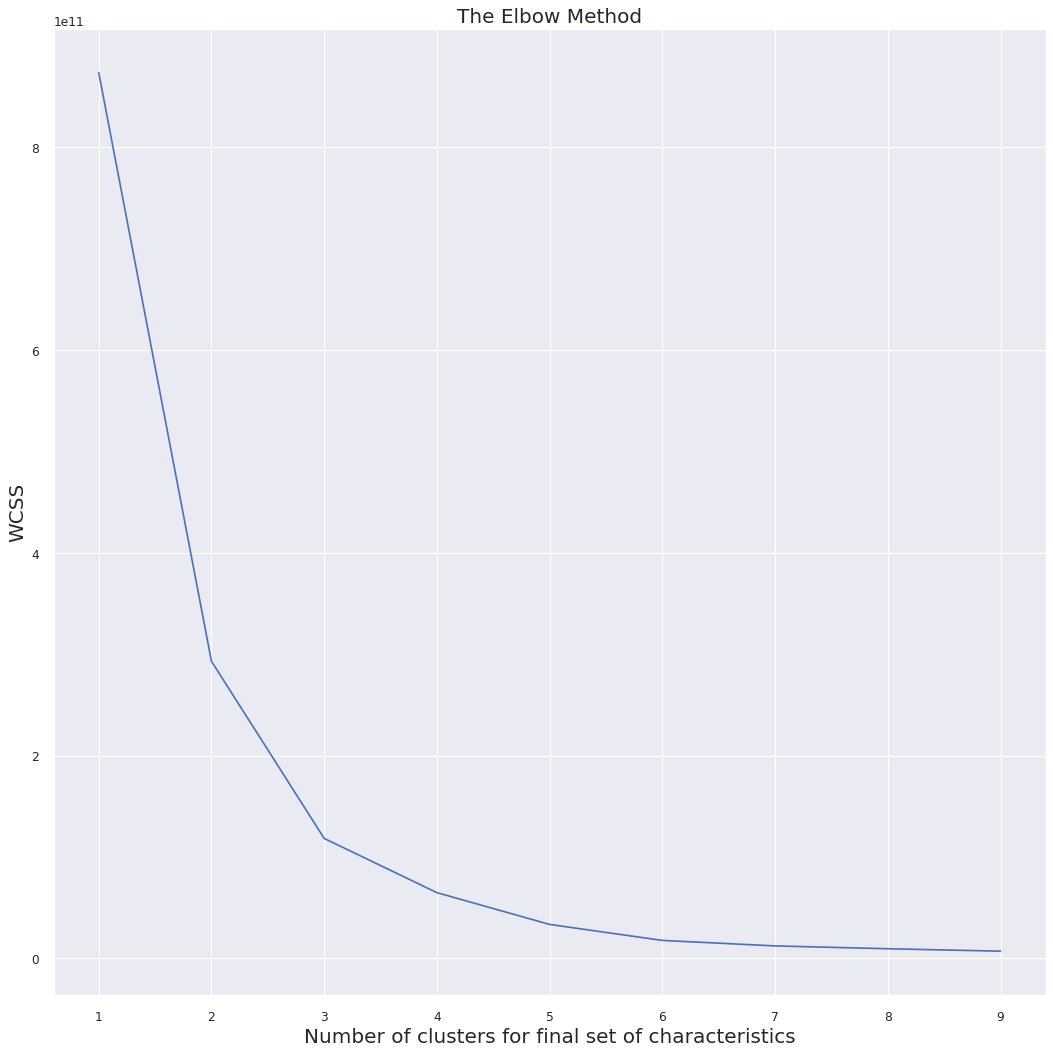

In [415]:
plt.figure(figsize=(16, 6), dpi=80)
# fig.set_size_inches(28.5, 20.5)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.plot(range(1,10),wcss)
plt.title("The Elbow Method", **axis_font)
plt.xlabel("Number of clusters for final set of characteristics",**axis_font)
plt.ylabel("WCSS",**axis_font)
plt.show()

In [237]:
noClusters = 6
km = KMeans(n_clusters = noClusters, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_means2 = km.fit_predict(fileWorkingReduced2)

### Calculating the Silhouette_Score to check if the number is matched correctly

In [238]:
score = silhouette_score(fileWorkingReduced2, km.labels_, metric="euclidean")
score

0.7248574713341203

### Checking the cluster numbed desicion with yellowbrick

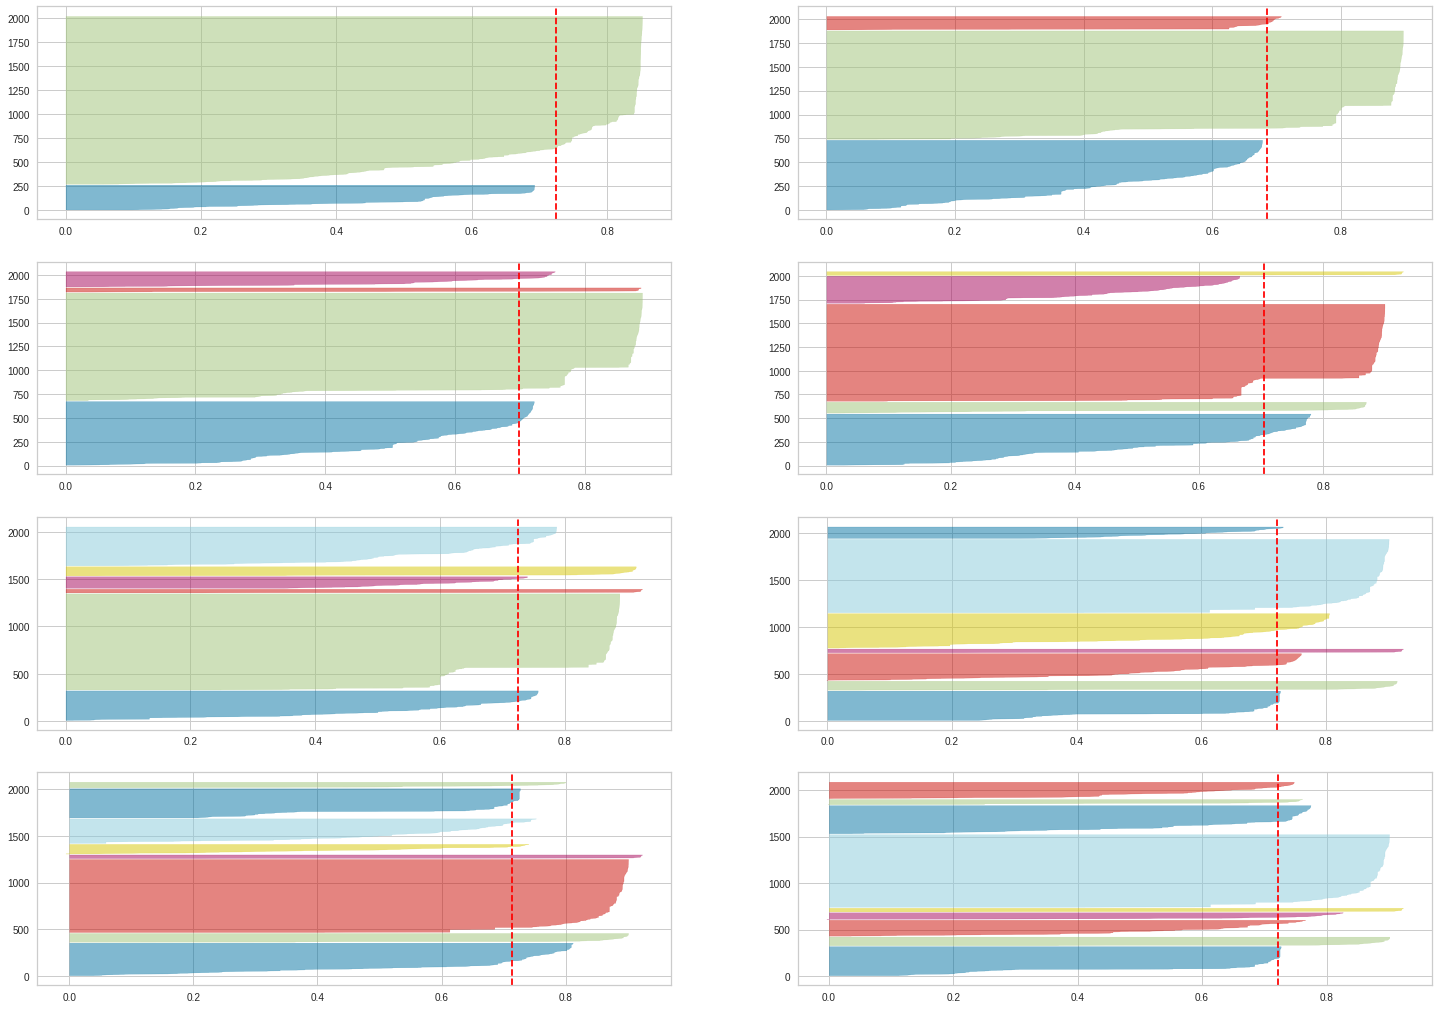

In [239]:
fig,ax = plt.subplots(4,2,figsize=(25,18))

for i in [2,3,4,5,6,7,8,9]:
    km = KMeans(n_clusters=i, init="k-means++",n_init=10, max_iter=100, random_state=42)
    q,mod = divmod(i,2)
#     print(q//10,mod)
    visualizer = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q - 1][mod])
    visualizer.fit(fileWorkingReduced2)

#### Adding found cluster numbers to dataframe

In [240]:
y_means2 = pd.DataFrame(y_means2)
workingFileClusters = pd.concat([workingFileClusters, y_means2], axis = 1)
workingFileClusters = workingFileClusters.rename(columns = {0: "Clusters2"})
workingFileClusters.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,apartment,...,business centre,24 hour front desk,restaurant,swimming pool,air conditioned,disabled access,spa & wellness centre,green_key,Clusters,Clusters2
0,1,22886,8,1,1,0.09102,32.47620,4.67,23,0.0,...,0,0,0,0,1,0,0,0,944,0
1,66,12,15,2,2,56.18580,-4.50023,7.25,1,0.0,...,1,0,0,1,0,0,1,0,236,2
2,68,15,4,3,3,24.46660,54.36660,1.16,84,0.0,...,1,0,0,1,1,0,0,0,517,2
3,73,15,5,3,3,24.49917,54.38133,2.76,248,0.0,...,1,0,0,1,1,1,1,1,403,2
4,168,22,4,4,4,30.40320,-9.59950,1.28,328,0.0,...,1,0,0,1,1,0,1,0,155,2
